In [ ]:
# Load your data and ensure datetime format
df = pd.read_csv("/Users/nicole.li/Downloads/revenue.csv")
df['ds'] = pd.to_datetime(df['ds'])

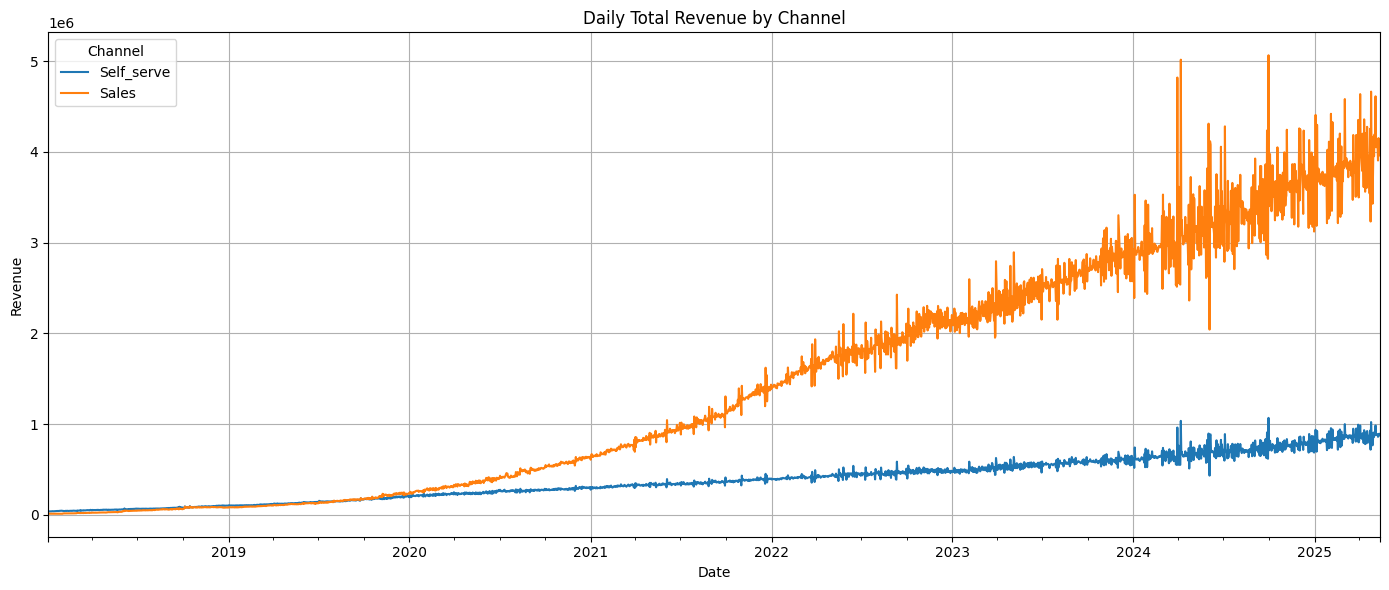

In [8]:
# visualization
import matplotlib.pyplot as plt

# Assuming df is already loaded and has columns: ds, sales_or_not, actual_revenue
df['ds'] = pd.to_datetime(df['ds'])

# Group and pivot data
grouped = df.groupby(['ds', 'sales_or_not'], as_index=False)['actual_revenue'].sum()
pivot_df = grouped.pivot(index='ds', columns='sales_or_not', values='actual_revenue')
pivot_df.columns = ['Self_serve', 'Sales']  # 0 → self_serve, 1 → Sales

# Plot
plt.figure(figsize=(14, 6))
pivot_df.plot(ax=plt.gca())
plt.title("Daily Total Revenue by Channel")
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.legend(title="Channel")
plt.grid(True)
plt.tight_layout()
plt.show()

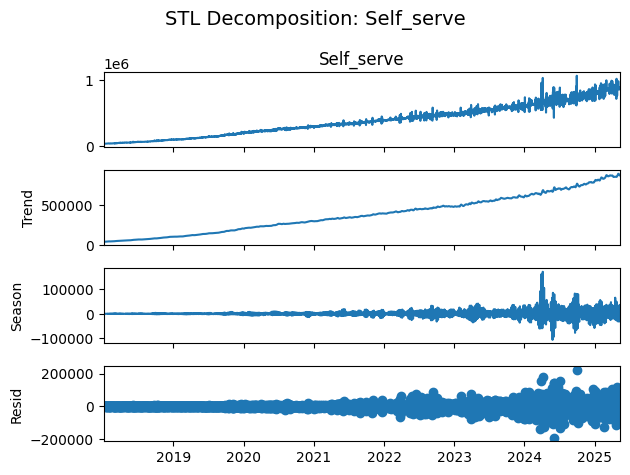

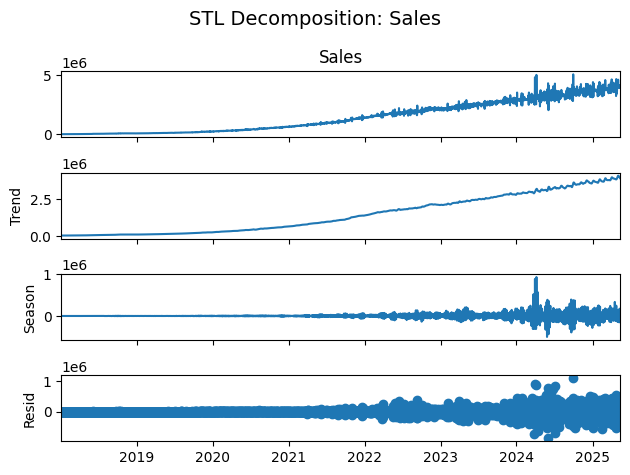

Self_serve → Trend Strength: 0.990, Residual Std Dev: 23394
Sales → Trend Strength: 0.992, Residual Std Dev: 114497


In [10]:
# time series decomposition for each channel
from statsmodels.tsa.seasonal import STL
import numpy as np

# Decompose and analyze
metrics = {}
for label in ['Self_serve', 'Sales']:
    series = pivot_df[label].dropna()
    stl = STL(series, period=7)
    result = stl.fit()

    # Plot STL
    result.plot()
    plt.suptitle(f"STL Decomposition: {label}", fontsize=14)
    plt.tight_layout()
    plt.show()

    # Calculate trend strength and residual std deviation (noise)
    resid_var = np.var(result.resid)
    trend_plus_resid_var = np.var(result.trend + result.resid)
    strength = max(0, 1 - resid_var / trend_plus_resid_var)
    noise = np.std(result.resid)

    metrics[label] = {
        'trend_strength': strength,
        'residual_stddev': noise
    }

# Print strength and noise
for label, vals in metrics.items():
    print(f"{label} → Trend Strength: {vals['trend_strength']:.3f}, Residual Std Dev: {vals['residual_stddev']:.0f}")

Self_serve → Trend Strength: 0.990, Residual Std Dev: 23394

Sales → Trend Strength: 0.992, Residual Std Dev: 114497

1	Both channels have exceptionally strong trend signals → Prophet, ARIMA, or even simple models will capture directionality well.
2	Residual noise is much lower for Self-Serve → more predictable and less volatile.
3	Self-Serve is lower volume but cleaner → easier to forecast with tight confidence intervals.
4	Sales has higher volume and volatility → may need more recent training windows and more flexible models (e.g., higher changepoint_prior_scale in Prophet).



In [26]:
from prophet import Prophet
import pandas as pd
import warnings

grouped = df.groupby(['ds', 'sales_or_not'], as_index=False)['actual_revenue'].sum()
test_start = grouped['ds'].max() - pd.Timedelta(days=79)
train_grouped = grouped[grouped['ds'] < test_start]
test_grouped = grouped[grouped['ds'] >= test_start]

# Train separate models and save forecasts by group
group_models = {}
group_forecasts = {}

for group_val, label in [(0, "Self-Serve"), (1, "Sales")]:
    # Training window
    g_train = train_grouped[train_grouped['sales_or_not'] == group_val].copy()
    if group_val == 0:
        window_start = g_train['ds'].min()  # full history
    else:
        window_start = test_start - pd.Timedelta(days=730)
        g_train = g_train[g_train['ds'] >= window_start]

    # Prophet config
    g_train = g_train.rename(columns={'actual_revenue': 'y'})
    model = Prophet(weekly_seasonality='auto', yearly_seasonality=True)

    if group_val == 1:
        model = Prophet(
            weekly_seasonality='auto',
            yearly_seasonality=True,
            changepoint_prior_scale=0.75,
            seasonality_mode='multiplicative'
        )
        model.add_seasonality(name='weekly_extra', period=7, fourier_order=10)

    # Fit
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        model.fit(g_train)

    # Forecast
    g_test = test_grouped[test_grouped['sales_or_not'] == group_val]
    future = pd.DataFrame({'ds': g_test['ds']})
    forecast = model.predict(future)

    # Save
    group_models[label] = model
    group_forecasts[label] = forecast[['ds', 'yhat']].merge(g_test, on='ds')

22:32:03 - cmdstanpy - INFO - Chain [1] start processing
22:32:03 - cmdstanpy - INFO - Chain [1] done processing
/Users/nicole.li/.pyenv/versions/3.10.11/lib/python3.10/site-packages/prophet/forecaster.py:1415: RuntimeWarning: divide by zero encountered in matmul
  comp = np.matmul(X, beta_c.transpose())
/Users/nicole.li/.pyenv/versions/3.10.11/lib/python3.10/site-packages/prophet/forecaster.py:1415: RuntimeWarning: overflow encountered in matmul
  comp = np.matmul(X, beta_c.transpose())
/Users/nicole.li/.pyenv/versions/3.10.11/lib/python3.10/site-packages/prophet/forecaster.py:1415: RuntimeWarning: invalid value encountered in matmul
  comp = np.matmul(X, beta_c.transpose())
/Users/nicole.li/.pyenv/versions/3.10.11/lib/python3.10/site-packages/prophet/forecaster.py:1550: RuntimeWarning: divide by zero encountered in matmul
  Xb_a = np.matmul(seasonal_features.values,
/Users/nicole.li/.pyenv/versions/3.10.11/lib/python3.10/site-packages/prophet/forecaster.py:1550: RuntimeWarning: overf

Self-Serve Forecast
  MAE:  $49,785
  MAPE: 5.60%



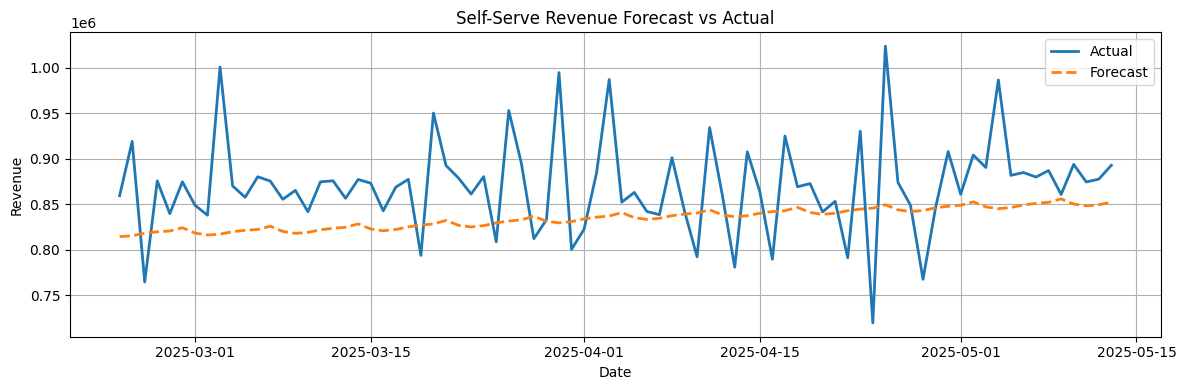

Sales Forecast
  MAE:  $193,640
  MAPE: 4.89%



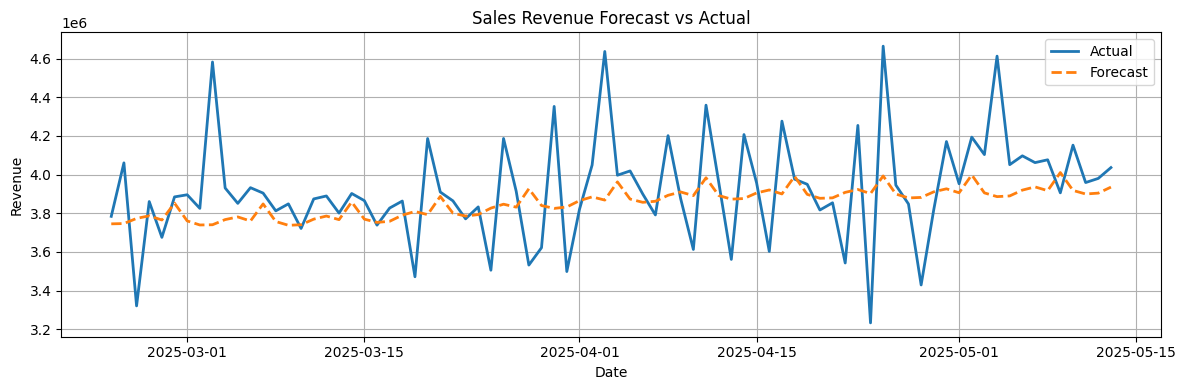

In [27]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
import numpy as np

for label in ['Self-Serve', 'Sales']:
    df_eval = group_forecasts[label].copy()

    # Evaluation
    mae = mean_absolute_error(df_eval['actual_revenue'], df_eval['yhat'])
    mape = (abs((df_eval['actual_revenue'] - df_eval['yhat']) / df_eval['actual_revenue'])).mean() * 100

    print(f"{label} Forecast")
    print(f"  MAE:  ${mae:,.0f}")
    print(f"  MAPE: {mape:.2f}%\n")

    # Plot
    plt.figure(figsize=(12, 4))
    plt.plot(df_eval['ds'], df_eval['actual_revenue'], label='Actual', linewidth=2)
    plt.plot(df_eval['ds'], df_eval['yhat'], label='Forecast', linestyle='--', linewidth=2)
    plt.title(f"{label} Revenue Forecast vs Actual")
    plt.xlabel("Date")
    plt.ylabel("Revenue")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

22:34:11 - cmdstanpy - INFO - Chain [1] start processing
22:34:11 - cmdstanpy - INFO - Chain [1] done processing


Sales Forecast — MAE: $193,640
Sales Forecast — MAPE: 4.89%


/Users/nicole.li/.pyenv/versions/3.10.11/lib/python3.10/site-packages/prophet/forecaster.py:1415: RuntimeWarning: divide by zero encountered in matmul
  comp = np.matmul(X, beta_c.transpose())
/Users/nicole.li/.pyenv/versions/3.10.11/lib/python3.10/site-packages/prophet/forecaster.py:1415: RuntimeWarning: overflow encountered in matmul
  comp = np.matmul(X, beta_c.transpose())
/Users/nicole.li/.pyenv/versions/3.10.11/lib/python3.10/site-packages/prophet/forecaster.py:1415: RuntimeWarning: invalid value encountered in matmul
  comp = np.matmul(X, beta_c.transpose())
/Users/nicole.li/.pyenv/versions/3.10.11/lib/python3.10/site-packages/prophet/forecaster.py:1550: RuntimeWarning: divide by zero encountered in matmul
  Xb_a = np.matmul(seasonal_features.values,
/Users/nicole.li/.pyenv/versions/3.10.11/lib/python3.10/site-packages/prophet/forecaster.py:1550: RuntimeWarning: overflow encountered in matmul
  Xb_a = np.matmul(seasonal_features.values,
/Users/nicole.li/.pyenv/versions/3.10.11/l

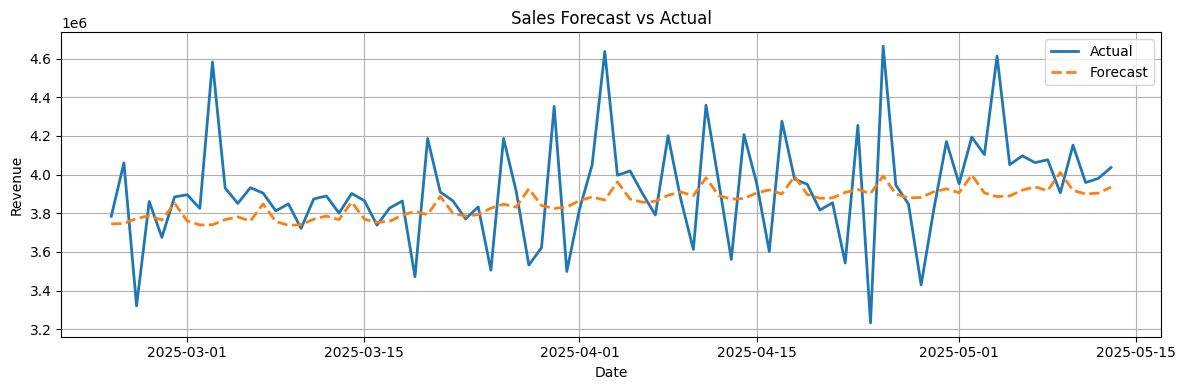

In [29]:

# Use raw data from last 2 years
g_train = train_grouped[train_grouped['sales_or_not'] == 1].copy()
g_train = g_train[g_train['ds'] >= test_start - pd.Timedelta(days=730)]
g_train = g_train.rename(columns={'actual_revenue': 'y'})

# Prophet config
model = Prophet(
    weekly_seasonality='auto',
    yearly_seasonality=True,
    changepoint_prior_scale=0.75,
    seasonality_mode='multiplicative'
)
model.add_seasonality(name='weekly_extra', period=7, fourier_order=10)

# Fit model
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    model.fit(g_train[['ds', 'y']])

# Forecast
g_test = test_grouped[test_grouped['sales_or_not'] == 1]
future = pd.DataFrame({'ds': g_test['ds']})
forecast = model.predict(future)
sales_forecast = forecast[['ds', 'yhat']].merge(g_test, on='ds')

# Evaluation
mae = mean_absolute_error(sales_forecast['actual_revenue'], sales_forecast['yhat'])
mape = (np.abs((sales_forecast['actual_revenue'] - sales_forecast['yhat']) / sales_forecast['actual_revenue'])).mean() * 100

print(f"Sales Forecast — MAE: ${mae:,.0f}")
print(f"Sales Forecast — MAPE: {mape:.2f}%")

# Plot
plt.figure(figsize=(12, 4))
plt.plot(sales_forecast['ds'], sales_forecast['actual_revenue'], label='Actual', linewidth=2)
plt.plot(sales_forecast['ds'], sales_forecast['yhat'], label='Forecast', linestyle='--', linewidth=2)
plt.title("Sales Forecast vs Actual")
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

10:15:34 - cmdstanpy - INFO - Chain [1] start processing
10:15:35 - cmdstanpy - INFO - Chain [1] done processing


Total Revenue Forecast — MAE: $228,306, MAPE: 4.72%


/Users/nicole.li/.pyenv/versions/3.10.11/lib/python3.10/site-packages/prophet/forecaster.py:1415: RuntimeWarning: divide by zero encountered in matmul
  comp = np.matmul(X, beta_c.transpose())
/Users/nicole.li/.pyenv/versions/3.10.11/lib/python3.10/site-packages/prophet/forecaster.py:1415: RuntimeWarning: overflow encountered in matmul
  comp = np.matmul(X, beta_c.transpose())
/Users/nicole.li/.pyenv/versions/3.10.11/lib/python3.10/site-packages/prophet/forecaster.py:1415: RuntimeWarning: invalid value encountered in matmul
  comp = np.matmul(X, beta_c.transpose())
/Users/nicole.li/.pyenv/versions/3.10.11/lib/python3.10/site-packages/prophet/forecaster.py:1550: RuntimeWarning: divide by zero encountered in matmul
  Xb_a = np.matmul(seasonal_features.values,
/Users/nicole.li/.pyenv/versions/3.10.11/lib/python3.10/site-packages/prophet/forecaster.py:1550: RuntimeWarning: overflow encountered in matmul
  Xb_a = np.matmul(seasonal_features.values,
/Users/nicole.li/.pyenv/versions/3.10.11/l

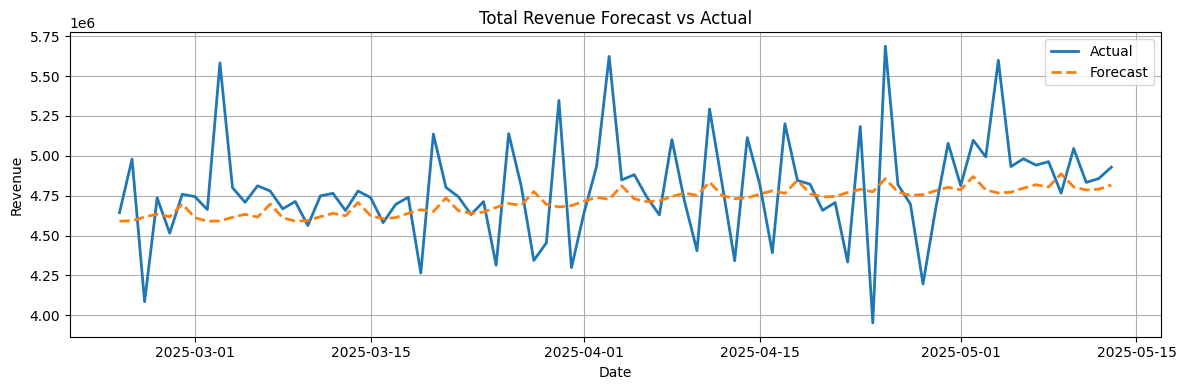

In [49]:

# Aggregate total daily revenue
daily_total = df.groupby('ds', as_index=False)['actual_revenue'].sum()
daily_total = daily_total.sort_values('ds')


# Use last 2 years for training
test_start = daily_total['ds'].max() - pd.Timedelta(days=79)
train_total = daily_total[(daily_total['ds'] < test_start) & (daily_total['ds'] >= test_start - pd.Timedelta(days=730))]
train_total = train_total.rename(columns={'actual_revenue': 'y'})

# Prophet model config
model = Prophet(
    weekly_seasonality='auto',
    yearly_seasonality=True,
    interval_width=0.95,
    changepoint_prior_scale=0.25,
    seasonality_mode='additive'
)
model.add_seasonality(name='weekly_extra', period=7, fourier_order=10)

# Fit
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    model.fit(train_total)

# Forecast horizon = test set
test_total = daily_total[daily_total['ds'] >= test_start]
future = pd.DataFrame({'ds': test_total['ds']})
forecast = model.predict(future)

# Merge + evaluate
result = forecast[['ds', 'yhat']].merge(test_total, on='ds')
mae = mean_absolute_error(result['actual_revenue'], result['yhat'])
mape = (np.abs((result['actual_revenue'] - result['yhat']) / result['actual_revenue'])).mean() * 100

print(f"Total Revenue Forecast — MAE: ${mae:,.0f}, MAPE: {mape:.2f}%")

# Plot
plt.figure(figsize=(12, 4))
plt.plot(result['ds'], result['actual_revenue'], label='Actual', linewidth=2)
plt.plot(result['ds'], result['yhat'], label='Forecast', linestyle='--', linewidth=2)
plt.title("Total Revenue Forecast vs Actual")
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# prophet is not a great model for this data. trying xgboost

Test window: 2025-02-23 00:00:00 → 2025-05-13 00:00:00
MAE: 267672.6720000006
MAPE: 5.478443197995282
XGBoost Daily Revenue Forecast — MAE: $267,673
XGBoost Daily Revenue Forecast — MAPE: 5.48%


/var/folders/0z/n5hjnn117cs9kjf25932c_vh0000gp/T/ipykernel_56768/534602563.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['yhat'] = model.predict(test[features])


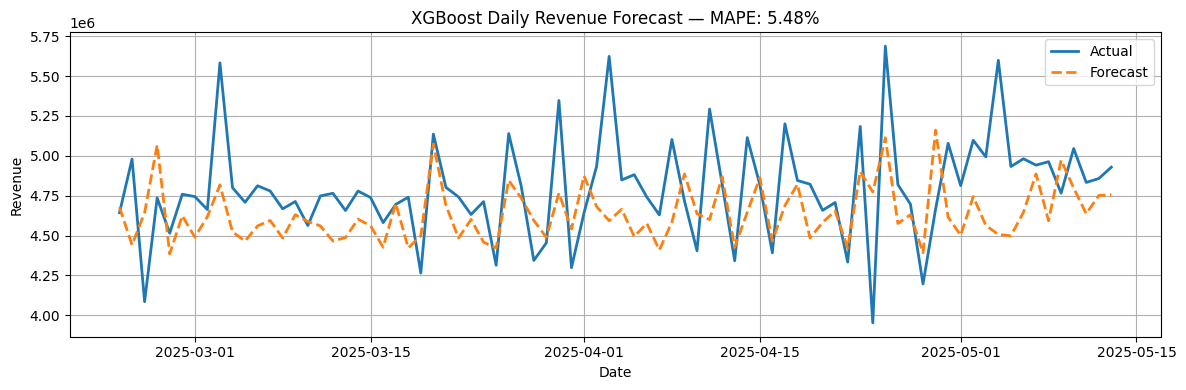

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error

# Load and prepare daily revenue
df['ds'] = pd.to_datetime(df['ds'])
daily_total = df.groupby('ds', as_index=False)['actual_revenue'].sum().sort_values('ds')
daily_total = daily_total.set_index('ds')

# Feature engineering
daily_total['lag_1'] = daily_total['actual_revenue'].shift(1)
daily_total['lag_7'] = daily_total['actual_revenue'].shift(7)
daily_total['roll_7_mean'] = daily_total['actual_revenue'].rolling(window=7).mean()
daily_total['dayofweek'] = daily_total.index.dayofweek
daily_total['is_weekend'] = (daily_total['dayofweek'] >= 5).astype(int)

# Drop NA
daily_total = daily_total.dropna()

# Define features
features = ['lag_1', 'lag_7', 'roll_7_mean', 'dayofweek', 'is_weekend']
target = 'actual_revenue'

# Split train/test
train = daily_total.iloc[:-80]
test = daily_total.iloc[-80:]

print("Test window:", test.index.min(), "→", test.index.max())
print("MAE:", mae)
print("MAPE:", mape)

# Train XGBoost
model = XGBRegressor(n_estimators=200, learning_rate=0.1, max_depth=3, random_state=42)
model.fit(train[features], train[target])

# Predict
test['yhat'] = model.predict(test[features])
mae = mean_absolute_error(test[target], test['yhat'])
mape = (np.abs((test[target] - test['yhat']) / test[target])).mean() * 100

# Results
print(f"XGBoost Daily Revenue Forecast — MAE: ${mae:,.0f}")
print(f"XGBoost Daily Revenue Forecast — MAPE: {mape:.2f}%")

# Plot
plt.figure(figsize=(12, 4))
plt.plot(test.index, test[target], label='Actual', linewidth=2)
plt.plot(test.index, test['yhat'], label='Forecast', linestyle='--', linewidth=2)
plt.title(f"XGBoost Daily Revenue Forecast — MAPE: {mape:.2f}%")
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [57]:
import pandas as pd
import numpy as np
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error

# Load and preprocess (if not already)
df['ds'] = pd.to_datetime(df['ds'])
daily_total = df.groupby('ds', as_index=False)['actual_revenue'].sum().sort_values('ds')
daily_total = daily_total.set_index('ds')

# Feature engineering
daily_total['lag_1'] = daily_total['actual_revenue'].shift(1)
daily_total['lag_7'] = daily_total['actual_revenue'].shift(7)
daily_total['lag_14'] = daily_total['actual_revenue'].shift(14)
daily_total['roll_7_mean'] = daily_total['actual_revenue'].rolling(window=7).mean()
daily_total['roll_14_mean'] = daily_total['actual_revenue'].rolling(window=14).mean()
daily_total['dayofweek'] = daily_total.index.dayofweek
daily_total['is_weekend'] = (daily_total['dayofweek'] >= 5).astype(int)
daily_total['dow_weekend'] = daily_total['dayofweek'] * daily_total['is_weekend']
daily_total = daily_total.dropna()

# Train/test split for 4/30
target_date = pd.Timestamp("2025-04-30")
train_start = target_date - pd.Timedelta(days=90)
train = daily_total.loc[train_start:target_date - pd.Timedelta(days=1)].copy()
test = daily_total.loc[[target_date]].copy()

# Define features
tuned_features = [
    'lag_1', 'lag_7', 'lag_14',
    'roll_7_mean', 'roll_14_mean',
    'dayofweek', 'is_weekend', 'dow_weekend'
]

X_train = train[tuned_features]
y_train = train['actual_revenue']
X_test = test[tuned_features]
y_test = test['actual_revenue']

# Train LightGBM model
lgbm_model = LGBMRegressor(n_estimators=60, learning_rate=0.1, max_depth=2, random_state=42)
lgbm_model.fit(X_train, y_train)

# Predict
yhat_lgbm = lgbm_model.predict(X_test)
mae = mean_absolute_error(y_test, yhat_lgbm)
mape = (abs((y_test.values[0] - yhat_lgbm[0]) / y_test.values[0])) * 100

# Output results
print(f"Prediction: ${yhat_lgbm[0]:,.0f}")
print(f"Actual:     ${y_test.values[0]:,.0f}")
print(f"MAE:        ${mae:,.0f}")
print(f"MAPE:       {mape:.2f}%")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000362 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 167
[LightGBM] [Info] Number of data points in the train set: 90, number of used features: 8
[LightGBM] [Info] Start training from score 4719216.516667
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

In [59]:
import pandas as pd
import numpy as np
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error

# Load and prepare your data
df['ds'] = pd.to_datetime(df['ds'])
daily_total = df.groupby('ds', as_index=False)['actual_revenue'].sum().sort_values('ds')
daily_total = daily_total.set_index('ds')

# Feature engineering
daily_total['lag_1'] = daily_total['actual_revenue'].shift(1)
daily_total['lag_7'] = daily_total['actual_revenue'].shift(7)
daily_total['lag_14'] = daily_total['actual_revenue'].shift(14)
daily_total['lag_28'] = daily_total['actual_revenue'].shift(28)

daily_total['roll_7_mean'] = daily_total['actual_revenue'].rolling(window=7).mean()
daily_total['roll_14_mean'] = daily_total['actual_revenue'].rolling(window=14).mean()
daily_total['roll_30_mean'] = daily_total['actual_revenue'].rolling(window=30).mean()

daily_total['dayofweek'] = daily_total.index.dayofweek
daily_total['is_weekend'] = (daily_total['dayofweek'] >= 5).astype(int)
daily_total['dow_weekend'] = daily_total['dayofweek'] * daily_total['is_weekend']
daily_total['month'] = daily_total.index.month

daily_total = daily_total.dropna()

tuned_features = [
    'lag_1', 'lag_7', 'lag_14', 'lag_28',
    'roll_7_mean', 'roll_14_mean', 'roll_30_mean',
    'dayofweek', 'is_weekend', 'dow_weekend', 'month'
]

# Train LightGBM on 90 days before 4/30
target_date = pd.Timestamp("2025-04-30")
train_start = target_date - pd.Timedelta(days=90)
train = daily_total.loc[train_start:target_date - pd.Timedelta(days=1)].copy()

X_train = train[tuned_features]
y_train = train['actual_revenue']

model = LGBMRegressor(n_estimators=60, learning_rate=0.1, max_depth=2, random_state=42)
model.fit(X_train, y_train)

# Predict May 1–30
forecast_dates = pd.date_range(start="2025-05-01", periods=30, freq="D")
results = []

for date in forecast_dates:
    if date not in daily_total.index:
        continue

    row = daily_total.loc[[date]]
    X = row[tuned_features]
    y_true = row['actual_revenue'].values[0]
    y_pred = model.predict(X)[0]
    mae = abs(y_true - y_pred)
    mape = mae / y_true * 100

    results.append({
        'date': date,
        'actual': y_true,
        'forecast': y_pred,
        'mae': mae,
        'mape': mape
    })

# Results
forecast_df = pd.DataFrame(results)
print(forecast_df)

# Overall error
print("\n--- 30-Day Forecast Summary ---")
print(f"Average MAE:  ${forecast_df['mae'].mean():,.0f}")
print(f"Average MAPE: {forecast_df['mape'].mean():.2f}%")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000373 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 233
[LightGBM] [Info] Number of data points in the train set: 90, number of used features: 11
[LightGBM] [Info] Start training from score 4719216.516667
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

In [62]:
# look at mape for spike vs non spike days to see how to improve
forecast_df['spike'] = forecast_df['actual'] > forecast_df['actual'].quantile(0.95)
print("Spike Day MAPE:", forecast_df[forecast_df['spike']]['mape'].mean())
print("Non-Spike MAPE:", forecast_df[~forecast_df['spike']]['mape'].mean())

Spike Day MAPE: 15.047974505023292
Non-Spike MAPE: 2.567018051984796


In [64]:
# tune the features to treat spike days differently
# Prep
df['ds'] = pd.to_datetime(df['ds'])
daily_total = df.groupby('ds', as_index=False)['actual_revenue'].sum().sort_values('ds')
daily_total = daily_total.set_index('ds')

# ==== Feature Engineering ====
daily_total['lag_1'] = daily_total['actual_revenue'].shift(1)
daily_total['lag_7'] = daily_total['actual_revenue'].shift(7)
daily_total['lag_14'] = daily_total['actual_revenue'].shift(14)
daily_total['lag_28'] = daily_total['actual_revenue'].shift(28)

daily_total['roll_7_mean'] = daily_total['actual_revenue'].rolling(window=7).mean()
daily_total['roll_14_mean'] = daily_total['actual_revenue'].rolling(window=14).mean()
daily_total['roll_30_mean'] = daily_total['actual_revenue'].rolling(window=30).mean()

# Spike-aware features
daily_total['roll_7_max'] = daily_total['actual_revenue'].rolling(window=7).max()
daily_total['pct_change_1_7'] = (daily_total['lag_1'] - daily_total['lag_7']) / daily_total['lag_7']
daily_total['roll_7_std'] = daily_total['actual_revenue'].rolling(window=7).std()

daily_total['dayofweek'] = daily_total.index.dayofweek
daily_total['is_weekend'] = (daily_total['dayofweek'] >= 5).astype(int)
daily_total['dow_weekend'] = daily_total['dayofweek'] * daily_total['is_weekend']
daily_total['month'] = daily_total.index.month

daily_total = daily_total.dropna()

# ==== Train/Test Split ====
target_date = pd.Timestamp("2025-04-30")
train_start = target_date - pd.Timedelta(days=90)
train = daily_total.loc[train_start:target_date - pd.Timedelta(days=1)].copy()

# ==== Feature List ====
tuned_features = [
    'lag_1', 'lag_7', 'lag_14', 'lag_28',
    'roll_7_mean', 'roll_14_mean', 'roll_30_mean',
    'roll_7_max', 'pct_change_1_7', 'roll_7_std',
    'dayofweek', 'is_weekend', 'dow_weekend', 'month'
]

X_train = train[tuned_features]
y_train = train['actual_revenue']

# ==== Train LightGBM ====
# Log-transform target
model = LGBMRegressor(n_estimators=60, learning_rate=0.1, max_depth=2, random_state=42)
model.fit(X_train, np.log1p(y_train))  # log1p handles zeros safely

# Predict and invert log
forecast_dates = pd.date_range(start="2025-05-01", periods=30, freq="D")
results = []

for date in forecast_dates:
    if date not in daily_total.index:
        continue

    row = daily_total.loc[[date]]
    X = row[tuned_features]
    y_true = row['actual_revenue'].values[0]
    y_pred = np.expm1(model.predict(X)[0])  # inverse log1p
    mae = abs(y_true - y_pred)
    mape = mae / y_true * 100

    results.append({
        'date': date,
        'actual': y_true,
        'forecast': y_pred,
        'mae': mae,
        'mape': mape
    })

# Evaluate
forecast_df = pd.DataFrame(results)
forecast_df['spike'] = forecast_df['actual'] > forecast_df['actual'].quantile(0.95)

print(forecast_df)

print("\n--- Log-Transformed Forecast Summary ---")
print(f"Avg MAPE:  {forecast_df['mape'].mean():.2f}%")
print(f"Median MAPE: {forecast_df['mape'].median():.2f}%")
print(f"Spike-Day MAPE: {forecast_df[forecast_df['spike']]['mape'].mean():.2f}%")
print(f"Non-Spike MAPE: {forecast_df[~forecast_df['spike']]['mape'].mean():.2f}%")



[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000525 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 313
[LightGBM] [Info] Number of data points in the train set: 90, number of used features: 14
[LightGBM] [Info] Start training from score 15.364450
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

alright it looks like spike days we are just out of ways to optimize, so lets see if we can find a pattern for those days


In [67]:
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Step 1: Label spikes
threshold = daily_total['actual_revenue'].quantile(0.95)
daily_total['is_spike'] = (daily_total['actual_revenue'] > threshold).astype(int)

# Step 2: Set training and test ranges
test_start = pd.Timestamp("2025-03-01")
test_end = pd.Timestamp("2025-05-13")
train_start = test_start - pd.Timedelta(days=90)

train = daily_total.loc[train_start:test_start - pd.Timedelta(days=1)].copy()
test = daily_total.loc[test_start:test_end].copy()

# Step 3: Train classifier
X_train = train[tuned_features]
y_train = train['is_spike']

clf = LGBMClassifier(n_estimators=50, max_depth=3, random_state=42)
clf.fit(X_train, y_train)

# Step 4: Predict and evaluate
X_test = test[tuned_features]
y_test = test['is_spike']
y_pred = clf.predict(X_test)

# Step 5: Evaluation
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=3))

[LightGBM] [Info] Number of positive: 45, number of negative: 45
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000511 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 314
[LightGBM] [Info] Number of data points in the train set: 90, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

Here, we have a decent spike day classifier, now forecast the spike days


In [68]:

# Step 1: Extract spike days from training set
spike_train = train[train['is_spike'] == 1].copy()

# Step 2: Log-transform the target
X_spike = spike_train[tuned_features]
y_spike = np.log1p(spike_train['actual_revenue'])

spike_model = LGBMRegressor(n_estimators=60, learning_rate=0.1, max_depth=2, random_state=42)
spike_model.fit(X_spike, y_spike)

# Step 3: Predict spikes in the test set
spike_test = test[test['is_spike'] == 1].copy()
X_test_spike = spike_test[tuned_features]
y_test_spike = spike_test['actual_revenue']
yhat_log = spike_model.predict(X_test_spike)
yhat = np.expm1(yhat_log)  # invert log1p

# Step 4: Evaluate
mae = mean_absolute_error(y_test_spike, yhat)
mape = np.mean(np.abs((y_test_spike - yhat) / y_test_spike)) * 100

print(f"Spike-Day Forecast Evaluation")
print(f"MAE: ${mae:,.0f}")
print(f"MAPE: {mape:.2f}%")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000298 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 163
[LightGBM] [Info] Number of data points in the train set: 45, number of used features: 11
[LightGBM] [Info] Start training from score 15.380667
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

In [69]:
# tuning the spike forecast model
# Use your existing daily_total dataframe

# Define tuned features
tuned_features = [
    'lag_1', 'lag_7', 'lag_14', 'lag_28',
    'roll_7_mean', 'roll_14_mean', 'roll_30_mean',
    'roll_7_max', 'pct_change_1_7', 'roll_7_std',
    'dayofweek', 'is_weekend', 'dow_weekend', 'month'
]

# Create spike-only training set
train_start = pd.Timestamp("2024-12-01")
test_start = pd.Timestamp("2025-03-01")
test_end = pd.Timestamp("2025-05-13")

train = daily_total.loc[train_start:test_start - pd.Timedelta(days=1)]
test = daily_total.loc[test_start:test_end]

spike_train = train[train['is_spike'] == 1]
spike_test = test[test['is_spike'] == 1]

X_train = spike_train[tuned_features]
y_train = np.log1p(spike_train['actual_revenue'])

X_test = spike_test[tuned_features]
y_test = spike_test['actual_revenue']

# Train tuned spike model
model = LGBMRegressor(
    n_estimators=100,
    learning_rate=0.05,
    max_depth=4,
    random_state=42
)
model.fit(X_train, y_train)

# Predict
yhat_log = model.predict(X_test)
yhat = np.expm1(yhat_log)

# Evaluate
mae = mean_absolute_error(y_test, yhat)
mape = np.mean(np.abs((y_test - yhat) / y_test)) * 100

print(f"Spike Forecast MAE: ${mae:,.0f}")
print(f"Spike Forecast MAPE: {mape:.2f}%")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000254 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 163
[LightGBM] [Info] Number of data points in the train set: 45, number of used features: 11
[LightGBM] [Info] Start training from score 15.380667
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

I then tried modeling residuals, but the MAPE actually increased from there, so we pretty much captured most signals and residuals might just be noise, and the model is probably overfitting

So now, lets try to combine the two models - selectively apply spike model whtn classifier predicts a spike day


In [72]:
# Build general-purpose model (log-transformed on all training days)
X_normal = train[tuned_features]
y_normal = np.log1p(train['actual_revenue'])

model_normal = LGBMRegressor(
    n_estimators=60,
    learning_rate=0.1,
    max_depth=2,
    random_state=42
)
model_normal.fit(X_normal, y_normal)
# Predict spike probabilities
spike_probs = clf.predict(X_test, raw_score=False)
spike_flags = (spike_probs == 1)

# Get predictions from both models
log_pred_spike = model.predict(X_test)  # log spike model
pred_spike = np.expm1(log_pred_spike)

log_pred_normal = model_normal.predict(X_test)
pred_normal = np.expm1(log_pred_normal)

# Conditional forecast
final_pred = np.where(spike_flags, pred_spike, pred_normal)
mae = mean_absolute_error(y_test, final_pred)
mape = np.mean(np.abs((y_test - final_pred) / y_test)) * 100

print(f"Production 2-Stage Forecast — MAE: ${mae:,.0f}")
print(f"Production 2-Stage Forecast — MAPE: {mape:.2f}%")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000607 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 314
[LightGBM] [Info] Number of data points in the train set: 90, number of used features: 14
[LightGBM] [Info] Start training from score 15.327239
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

the 2 stage model is not showing improved performance, probably on borderline cases switching to spike model may not help. so lets try using spike probability instead of a hard flag

In [74]:
# Step 1: Spike probabilities from classifier
p_spike = clf.predict_proba(X_test)[:, 1]

# Step 2: Predictions from both models
log_pred_spike = model.predict(X_test)         # this is your spike model
log_pred_normal = model_normal.predict(X_test) # this is your general model

# Step 3: Convert to actual scale
pred_spike = np.expm1(log_pred_spike)
pred_normal = np.expm1(log_pred_normal)

# Step 4: Weighted average
final_pred = pred_normal * (1 - p_spike) + pred_spike * p_spike

# Step 5: Evaluate
mae = mean_absolute_error(y_test, final_pred)
mape = np.mean(np.abs((y_test - final_pred) / y_test)) * 100

print(f"Probability-Weighted Forecast — MAE: ${mae:,.0f}")
print(f"Probability-Weighted Forecast — MAPE: {mape:.2f}%")

Probability-Weighted Forecast — MAE: $236,774
Probability-Weighted Forecast — MAPE: 4.67%


	•	MAPE: 4.67%, slightly worse than hard-switch (4.46%)
	•	Conclusion: the classifier probability signal is not calibrated tightly — it’s likely “soft” and overweights spike model on mild/non-spike days.

This marks the end of the notebook. The model is not perfect, but it does a decent job of forecasting daily revenue. It's at a good point to summarize what I have learned and tried so far before diving even deeper into tuning the model as the marginal return is getting lower.